In [1]:
import pandas as pd
import numpy as np
from miceforest import ImputationKernel

from pygam import LogisticGAM, s, f
from pygam.datasets import default

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [19]:
df_raw = pd.read_csv('../data/telecom_customer_churn.csv')
df_population = pd.read_csv('../data/telecom_zipcode_population.csv')

df = df_raw.copy()
df = df.query('`Customer Status` != "Joined"').reset_index(drop=True)

# join population by zip-code
df = pd.merge(left=df, right=df_population, on='Zip Code')

# remove unwanted columns
dropped_columns = ['Customer ID', 'Churn Category', 'Churn Reason', 'Latitude', 'Longitude', 'Zip Code']
df = df[[col for col in df.columns if col not in dropped_columns]]

# impute categoricals as NA
impute_na = ['Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 'Premium Tech Support', 
             'Streaming TV', 'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Multiple Lines']

df[impute_na] = df[impute_na].fillna('NA')
df['Offer'] = df['Offer'].fillna('No Offer')

# fix data types
categorical_columns = ['Gender', 'Married', 'City', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service', 
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan', 
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music', 
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method',
                       'Customer Status']
df[categorical_columns] = df[categorical_columns].astype('category')

arranged_columns = list(df.columns[:-2])
arranged_columns.extend(['Population', 'Customer Status'])
df = df[arranged_columns]

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1], 
                                                                test_size=0.2, 
                                                                random_state=42)

rare_cities = df_X_train['City'].value_counts().index[df_X_train['City'].value_counts() <= 5]

df_X_train['City'] = df_X_train['City'].astype('object')
df_X_train.loc[df_X_train['City'].isin(rare_cities), 'City'] = 'Rare City'
df_X_train['City'] = df_X_train['City'].astype('category')

mice_kernel = ImputationKernel(
    data = df_X_train,
    save_all_iterations = True,
    random_state = 42
)

mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

df_X_train_imp = mice_imputation.copy()
df_X_train_imp_subset = df_X_train_imp[['Contract', 'Number of Referrals', 'Tenure in Months', 
                                        'Number of Dependents', 'Payment Method', 'Total Revenue', 'Total Charges', 
                                        'Monthly Charge', 'Online Security', 'Total Long Distance Charges']]

df_X_train_imp_subset_dummies = pd.get_dummies(df_X_train_imp_subset, dtype='float')

y_train_numeric = df_y_train.map({'Stayed': 0, 'Churned': 1}).astype('float')

/home/vscode/.venv/lib/python3.10/site-packages/miceforest/ImputationKernel.py:370: UserWarning: [City] have very rare categories, it is a good idea to group these, or set the min_data_in_leaf parameter to prevent lightgbm from outputting 0.0 probabilities.
  warn(


In [25]:
gam = \
    LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15))

gam.gridsearch(df_X_train_imp_subset_dummies.values, y_train_numeric)


  0% (0 of 11) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  9% (1 of 11) |##                       | Elapsed Time: 0:00:01 ETA:   0:00:11
 18% (2 of 11) |####                     | Elapsed Time: 0:00:01 ETA:   0:00:07
 27% (3 of 11) |######                   | Elapsed Time: 0:00:02 ETA:   0:00:06
 36% (4 of 11) |#########                | Elapsed Time: 0:00:02 ETA:   0:00:05
 45% (5 of 11) |###########              | Elapsed Time: 0:00:03 ETA:   0:00:03
 54% (6 of 11) |#############            | Elapsed Time: 0:00:03 ETA:   0:00:02
 63% (7 of 11) |###############          | Elapsed Time: 0:00:04 ETA:   0:00:01
 72% (8 of 11) |##################       | Elapsed Time: 0:00:04 ETA:   0:00:01
 81% (9 of 11) |####################     | Elapsed Time: 0:00:04 ETA:   0:00:00
 90% (10 of 11) |#####################   | Elapsed Time: 0:00:05 ETA:   0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + f(7) + f(8) + f(9) + f(10) + f(11) + f(12) + f(13) + f(14) + f(15) + intercept,
   tol=0.0001, verbose=False)

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=2)
print(axs.shape)
axs

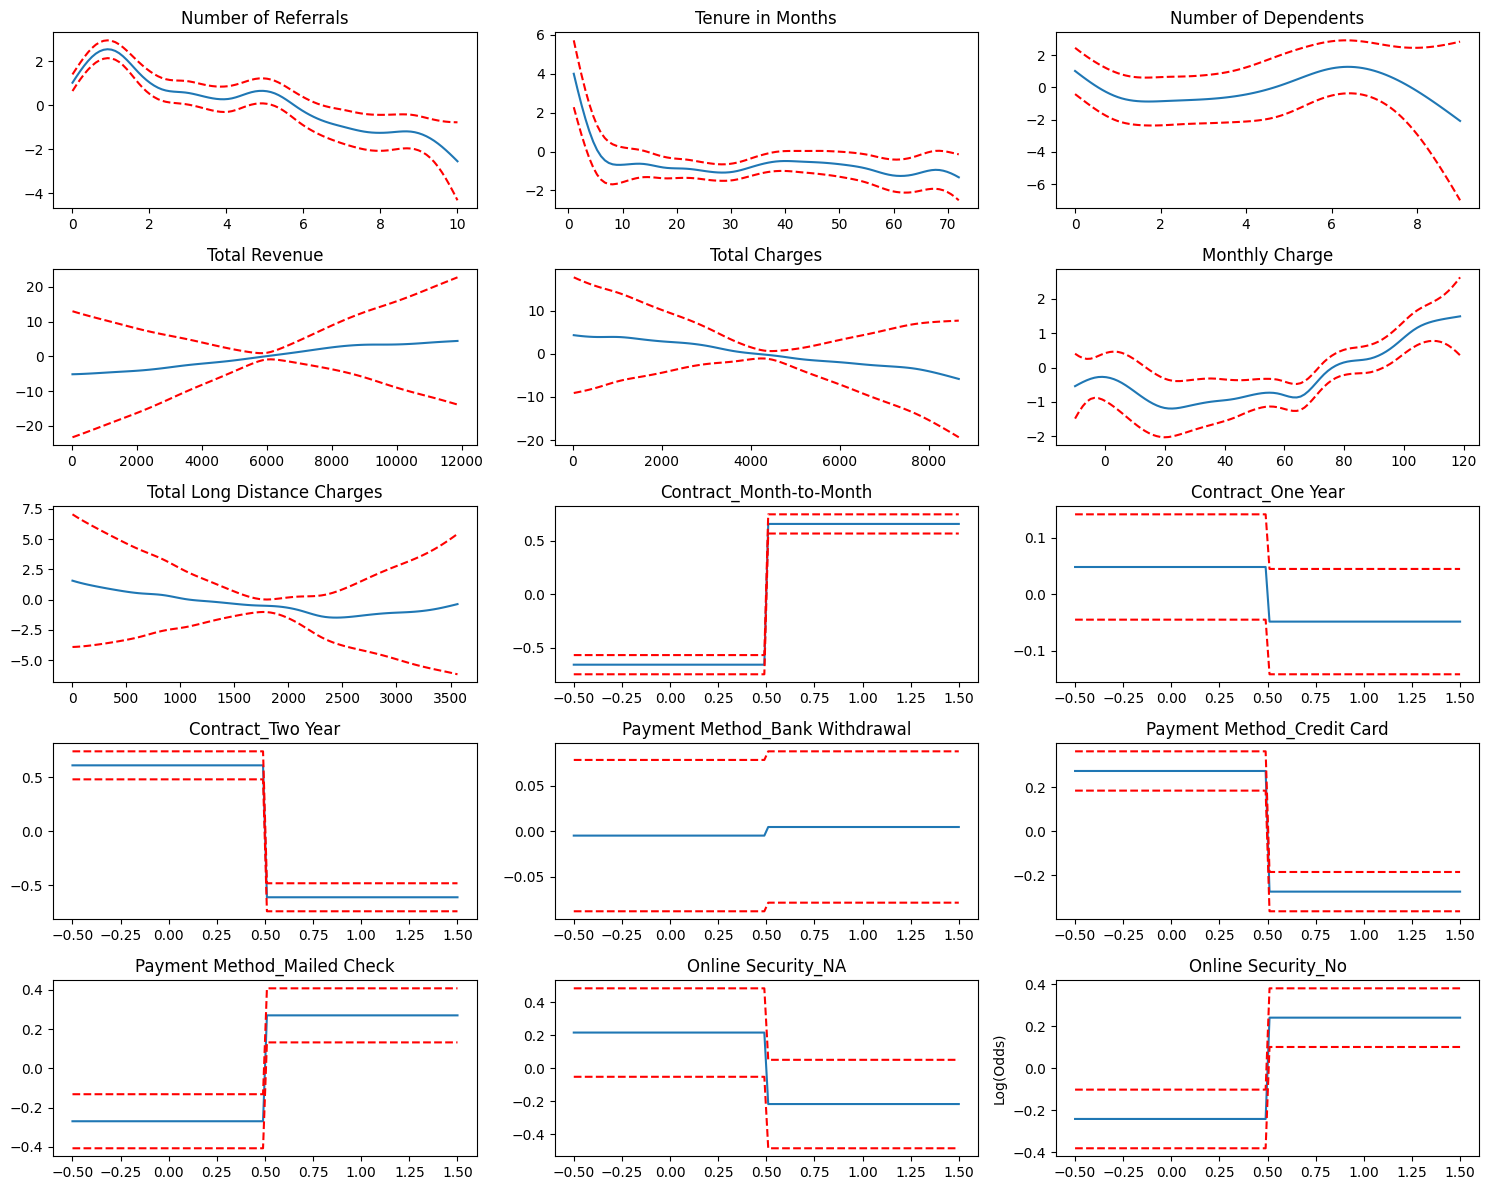

In [42]:
fig, axs = plt.subplots(5, 3, figsize=(15, 12))
titles = df_X_train_imp_subset_dummies.columns

for i, ax in enumerate(axs.ravel()):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c='r', ls='--')
    ax.set_title(titles[i]);

plt.ylabel("Log(Odds)")
plt.tight_layout()

In [ ]:
gam.predict()